# Práctica: Algoritmo Genético Simple

**Ingeniería Electrónica**

**Inteligencia Artificial**

**06/05/2020**

En esta práctica, se revisa la implementación de una algoritmo de optimización metaheurístico: un algortimo genético. 

Un **algoritmo genético** (GA) es una técnica de optimización y búsqueda basada en los principios de **Genética y Selección Natural**. Con frecuencia se usa para encontrar soluciones óptimas o casi óptimas para problemas difíciles que de otra manera tomarían mucho tiempo en resolverse. Se utiliza con frecuencia para resolver problemas de optimización, en investigación y machine learning.

GA genera una población, los individuos en esta población (a menudo llamados cromosomas) tienen un estado dado. Una vez que se genera la población, el estado de estos individuos se evalúa y califica según su valor. Los mejores individuos son luego tomados y cruzados, con el objetivo de generar "mejores" descendientes, para formar la nueva población. En algunos casos, los mejores individuos de la población se preservan para garantizar "buenos individuos" en la nueva generación.

Para explicar esto, se define un problema que consiste en encontrar las rutas factibles entre intersecciones de un mapa utilizando una matriz de adyacencia para representar al mismo.

Las funciones básicas de un algoritmo genético son identificadas más adelante.

## Librerías adicionales

Ejecutar los siguientes comandos en la terminal para instalar las librerías necesarias:

   * conda install -c anaconda numpy
   * conda install -c conda-forge matplotlib
   * conda install -c anaconda seaborn

In [26]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns 
import random

## Incializar mapa

Lo primero es crear un mapa de manera aleatoria.
El mapa tendrá la forma de una **matriz de adyacencia** $x$, una matriz **nxn** donde cada fila y columna corresponden a una intersección (vértice) en un mapa.

$x_{ij}$ representa la distancia de la posición $i$ a la posición $j$. También podría considerarse como cualquier otra medida que represente un peso, pero se requiere una matriz con valores numéricos.

Si no existen conexiones directas entre las intersecciones, se asigna un 0.
Por ejemplo, si no es posible ir directamente de $i$ a $j$, entonces $x_{ij}$ = 0. 


<img style="float:left;" src="codigo_practica_img/codigo_practica_img1.png"> </img>

In [27]:
def initialize_map(p_zero, N):
    the_map = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
    return the_map
initialize_map(0,5)

array([[0.        , 0.89251182, 0.45908333, 0.70158594, 0.93220115],
       [0.89251182, 0.        , 0.19080208, 0.67646537, 0.54793783],
       [0.45908333, 0.19080208, 0.        , 0.6825561 , 0.86792006],
       [0.70158594, 0.67646537, 0.6825561 , 0.        , 0.8032195 ],
       [0.93220115, 0.54793783, 0.86792006, 0.8032195 , 0.        ]])

## Generar la población inicial

La función `create_new_member` crea una nueva ruta aleatoria (con cualquier cantidad de pasos).
La estructura de la ruta será un vector de enteros donde cada valor es el siguiente paso en la ruta.

Todos comienzan en 0, por lo que el primer valor en el vector indicará a dónde intentar ir después.
Es decir, si $v_{i}$ = 4, eso correspondería a $x_{0,4}$ en el mapa que se creó en la inicialización.
    
N es el tamaño del mapa, por lo que se debe asegurar que no se genere ningún valor que exceda el tamaño del mapa.



La función `create_starting_population` simplemente crea una población de diferentes rutas de un tamaño fijo.

<img style="float:left;" src="codigo_practica_img/codigo_practica_img2.png"> </img>

<img style="float:left;" src="codigo_practica_img/codigo_practica_img3.png"> </img>

In [28]:
def create_new_member(the_map):
    N = len(the_map)
    route = np.zeros(1, dtype = int)
    go = True
    i = 1
    while go:
        possible_values = np.nonzero(the_map[route[i-1]])
        proposed_value = random.randint(0, len(possible_values[0])-1)
        route= np.append(route, possible_values[0][proposed_value])
        if route[i] == N-1:
            go = False
        else:
            i += 1
    return route        

In [29]:
def create_starting_population (size, the_map):
    population = []
    for i in range(0, size):
        population.append(create_new_member(the_map))
    return population

## Calcular aptitud

<img style="float:left;" src="codigo_practica_img/codigo_practica_img4.png"> </img>

<img style="float:left;" src="codigo_practica_img/codigo_practica_img5.png"> </img>

In [30]:
def fitness (route, the_map):
    score = 0
    for i in range(1, len(route)):
        if (the_map[route[i-1]][route[i]] == 0) and i != len(the_map)-1:
            print("RUTA NO VALIDA")
            print(route)
            print(the_map)
        score = score + the_map[route[i-1]][route[i]]
    return score   


In [31]:
def score_population (population, the_map):
    scores = []
    for i in range(0, len(population)):
        scores += [fitness(population[i], the_map)]
    return scores    

## Selección

<img style="float:left;" src="codigo_practica_img/codigo_practica_img6.png"> </img>

In [38]:
def pick_mate(scores):
    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp]= np.arange(len(array))
    fitness = [len(ranks) - x for x in ranks]
    cum_scores = copy.deepcopy(fitness)
    for i in range(1, len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
    probs = [x / cum_scores[-1] for x in cum_scores]
    rand = random.random()
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i

## Cruce

Para este ejemplo, se debe asegurar que cuando las dos rutas se crucen, las rutas resultantes produzcan una **ruta válida**. Es decir, que los puntos de cruce deben estar en el mismo valor de posición en el mapa.

<img style="float:left;" src="codigo_practica_img/codigo_practica_img7.png"> </img>

In [33]:
def crossover(a, b):
    common_elements = set(a) & set(b)
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a))
        value = random.sample(common_elements, 1)
    cut_a = np.random.choice(np.where(np.isin(a, value))[0])  
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])  
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:]) 
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
    return( new_a, new_b)

## Mutación

<img style="float:left;" src="codigo_practica_img/codigo_practica_img8.png"> </img>

In [45]:
def mutate (route, prob, the_map):
    new_route = copy.deepcopy(route)
    for i in range(1, len(new_route)):
        if random.random() < prob:
            go = True
            while go:
                possible_values = np.nonzero(the_map[new_route[i-1]])
                proposed_value = random.randint(0, len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])
                
                if new_route[i] == len(the_map)-1:
                    go = False
                else:
                    i += 1
    return new_route                    

## Graficar mejor ruta actual

<img style="float:left;" src="codigo_practica_img/codigo_practica_img9.png"> </img>

In [35]:
def plot_best(the_map, route, iteration_number):
    ax = sns.heatmap(the_map)
    
    x = [0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(the_map) - 0.5]
    y = [0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(the_map) - 0.5]
    
    plt.plot(x, y, marker = 'o', linewidth = 4, markersize = 12, linestyle = '-', color = 'white')
   # plt.savefig('plots/new100plot_%i.png' %(iteration_number), dpi=300)
    plt.show()

# Ejecución principal

In [36]:
def main():
    
    # parámetros
    sparseness_of_map = 0.95
    size_of_map = 100
    population_size = 30
    number_of_iterations = 50
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    
    # inicializar el mapa y guardarlo en una variable
    the_map = initialize_map(sparseness_of_map, size_of_map)

    # generar la población inicial
    population = create_starting_population(population_size, the_map)

    last_distance = 1000000000
    # para un gran número de iteraciones hacer:
        
    for i in range(0,number_of_iterations):
        new_population = []
        
        # evaluar la aptitud de la población actual
        scores = score_population(population, the_map)

        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = fitness(best, the_map)
        
        if distance != last_distance:
            print('Iteración %i: La mejor actual es %i pasos para una distancia de %f' % (i, number_of_moves, distance))
            plot_best(the_map, best, i)

        # permitir que los miembros de la población se reproduzcan según su puntaje relativo
            # es decir, si su puntaje es más alto, es más probable que se reproduzcan        
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)])
            new_population = new_population + [new_1, new_2]
  
        # mutar
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        # mantener a los mejores miembros de la generación anterior
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
        # agregar nuevos miembros al azar
        while len(new_population) < population_size:
            new_population += [create_new_member(the_map)]
            
        #reemplazar la antigua población con una copia
        population = copy.deepcopy(new_population)
                
        last_distance = distance
        
    # graficar los resultados
    

Invocar a la función a la función main:

Nota: Prueben cambiando los valores de los parametros en la celda anterior.

Iteración 0: La mejor actual es 19 pasos para una distancia de 10.033541


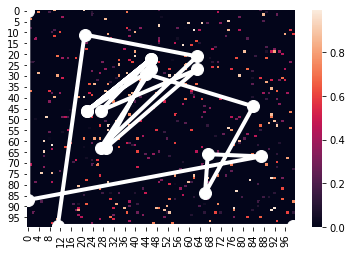

Iteración 1: La mejor actual es 7 pasos para una distancia de 1.287129


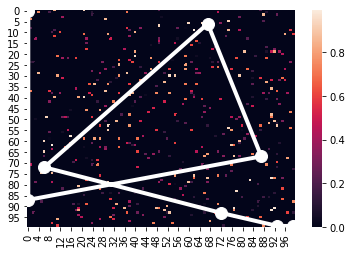

Iteración 3: La mejor actual es 5 pasos para una distancia de 0.929698


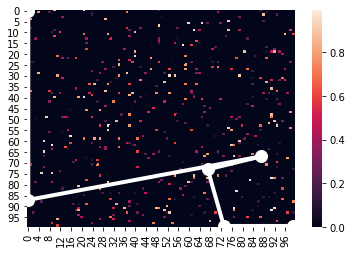

In [46]:
main()